Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [11]:
NAME = ""
ID = ""

---

# Lab 13: Reinforcement Learning (RL)

Today we'll have a gentle introduction to reinforcement learning.
The material in today's lab comes from these references:

 - Pytorch 1.x Reinforcement Learning Cookbook (Packtpub)
 - Hands-On Reinforcement Learning for Games (Packtpub)
 - https://www.kdnuggets.com/2018/03/5-things-reinforcement-learning.html
 - Reinforcement Learning: An Introduction (Sutton et al.)
 - https://github.com/werner-duvaud/muzero-general (simulator code)


## Reinforcement learning

Reinforcement Learning (RL) is a machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback on its actions and experiences.
RL uses rewards and punishment as signals for "good" and "bad" behavior.

Generally, at each step, the agent outputs an action, which is input to the environment. The environment evolves according to its dynamics, the agent observes the new state of the environment
and (optionally) a reward, and the process continues until hopefully the agent learns what behavior maximizes its reward.

<img src="img/RL.jpg" title="Introduction" style="width: 600px;" />


## Markov decision process (MDP)

A MDP is a discrete-time stochastic control process. The MDP model is based on the idea of an environment that evolves as a Markov chain.

### Markov chain

A Markov chain is a model of the dynamics of a discrete time system that obeys the (first order) "Markov property," meaning that the state $s^{t+1}$ at time
$t+1$ is conditionally independent of the state at times $0, \ldots, t-1$ given the state at time $t$, i.e.,

$$ p(s^{t+1} \mid s^t, s^{t-1}, \ldots, s^0) = p(s^{t+1} \mid s^t). $$

Informally, we might say that the current state is all you need to know to predict the next state.

More precisely, a Markov chain is defined by a set of possible states $S={s_0, s_1, \ldots, s_n}$ and a transition matrix $T(s,s')$
containing the propbabilities of state $s$ transitioning to state $s'$. Here is a visualization of a simple Markov chain:

<img src="img/RL_markov.png" title="Markov chain" style="width: 600px;" />

You might be interested in [this Markov chain simulator](https://setosa.io/ev/markov-chains/).

Now, the dynamics of the environment in a MDP are slightly different from that of a simple Markov chain. We have to consider how the agent's
actions affect the system's dynamics. At each time step, rather than just
transitioning randomly to the next state, we add the agent's action as an external input or disturbance $a \in A$, so (assuming a small number of discrete
states and actions) the transition probabilities become a 3D tensor of size $|S|\times |A|\times |S|$
mapping each state/action pair to a probability distribution over the states.

### A simple MDP

Suppose we have three states and two actions and that the state/action transition tensor is as follows:

<img src="img/RL_statetrans.png" title="" style="width: 200px;" />

To complete our simple MDP, we need a *reward function* $R$ and a *discount factor* $\gamma$. 
Suppose $R = [ 1, 0, -1 ]$ and $\gamma = 0.5$. Let's define our MDP in Python with PyTorch tensors:


In [12]:
import torch

# State transition function

T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]])

# Reward function

R = torch.tensor([1.,0.,-1.])

# Discount factor

gamma = 0.5

### The agent's goal

Once the MDP is defined, the agent's goal is to maximize its expected reward. If we start in state $s^0$ and perform a series
of actions $a^0, a^1, \ldots a^{T-1}$ placing us in state $s^1, s^2, \ldots s^T$, we obtain the total reward

$$ \sum_{t=0}^T \gamma^{t} R(s^t).$$

The agent's goal is to behave so as to maximize the expected total reward. To do so,
it should come up with a policy $\pi : S \times A \rightarrow \mathbb{R}$ giving a probability distribution
over actions that can be executed in each state, then when in state $s$, sample action $a$ according to that
distribution $\pi(s,\cdot)$, and repeat.

Now the agent's goal can be clearly specified as finding an optimal policy

$$ \pi^* = \textrm{argmax}_\pi \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1})}\left[ \sum_{t=0}^T \gamma^{t} R(s^t) \right]$$

Under a particular policy $\pi$, then, the *value* of state $s$ is the expected reward we obtain by following $\pi$ from state $s$:

$$ V^\pi(s) = \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1}) \mid s^0=s}\left[ R(s) + \sum_{t=1}^T \gamma^{t} R(s^t) \right]$$

The value function clearly obeys the *Bellman equations*

$$ V^\pi(s) = R(s) + \gamma \sum_{s',a'} \pi(s,a') T(s,a',s') V^\pi(s'). $$ 

### How good is a policy? Policy evaluation

To determine how good a particular policy is, we use policy evaluation.
Policy evaluation is an iterative algorithm. It starts with arbitrary values for each state
and then iteratively updates the values based on the Bellman equations until the values converge.

You can see this algorithm's pseudocode in Sutton's book on page 75.

Here we compute the value of the three states in our MDP assuming the agent always peforms the first action:

In [13]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (rewards[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

threshold = 0.0001

policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]])

V = policy_evaluation(policy_optimal, T, R, gamma, threshold)
print(V)

tensor([ 1.6786,  0.6260, -0.4821])


### Policy iteration

Policy iteration starts with a random policy then uses policy evaluation and the resulting values to iteratively improve the policy until an optimal policy is obtained. It is, however,
slow, due to the policy evaluation loop within the policy iteration loop.

Here's an implementation using a slightly different formulation fo the reward as a function $R(s,a,s')$ of the current state $s$, action taken $a$, and resulting state $s'$:

In [14]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = int(policy[state].item())
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                V_temp[state] += trans_prop * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

def policy_improvement(trans_matrix, rewards, gamma):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.zeros(n_state)

    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for new_state in range(n_state):
                trans_prop = trans_matrix[state, action, new_state]
                reward = rewards[state, action, new_state]
                v_actions[action] += trans_prop * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

def policy_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(policy, trans_matrix, rewards, gamma, threshold)
        policy_improved = policy_improvement(trans_matrix, rewards, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

# Reward R(s,a,a') example

R2 = torch.tensor([[[0.1,0.,-0.2],
                    [0.2,0.,-0.1]],
                   [[0.3,0.,-0.5],
                    [0.1,0.,-0.2]],
                   [[0.2,0.,-0.1],
                    [1.,0.,-1.]]])

V_optimal, optimal_policy = policy_iteration(T, R2, gamma, threshold)
print(V_optimal)
print(optimal_policy)

tensor([0.1352, 0.2405, 0.1829])
tensor([0., 0., 0.])


### Value iteration

Value iteration is a much more efficient way to obtain the optimial policy. It calculates the value
of each state on the assumption that the agent will deterministically select the action $a$ in state $s$
that maximizes the expected reward after that. Once this value converges, the optimal policy is just
to select the best action according to that value function:

$$ V^*(s)=R(s) + \max_a \gamma \sum_{s'} T(s,a,s') V^*(s') $$

$$ \pi^*(s) = \mathrm{argmax}_a \sum_{s'} T(s, a, s') V^*(s').$$

Instead of taking the expectation (average) of values across all actions, we pick the action that achieves the maximal policy values.
As above, we use the slightly different formulation in which the reward $R(s,a,s')$ is given based on initial state, action, and resulting state:

$$ V^*(s) = \max_a \sum_{s'} T(s,a,s') [ R(s,a,s') + \gamma V^*(s')]$$
$$ \pi^* = \mathrm{argmax}_a \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma V^*(s')]$$

Here's sample code:

In [15]:
def value_iteration(trans_matrix, rewards, gamma, threshold):
    n_state = trans_matrix.shape[0]
    n_action = trans_matrix.shape[1]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                for new_state in range(n_state):
                    trans_prop = trans_matrix[state, action, new_state]
                    reward = rewards[state, action, new_state]
                    v_actions[action] += trans_prop * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V-V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

V = value_iteration(T, R2, gamma, threshold)
print(V)

tensor([0.1352, 0.2405, 0.1829])


### Exercise

Write some code now to find the optimal policy based on the values you got from value iteration above. Do you get the same result as for
policy iteration?

## OpenAI Gym

Looking at policies in matrix form is a bit difficult.

A popular simulation environment for RL is OpenAI Gym.

[OpenAI](https://openai.com) is a research company trying to develop systems exhibiting *artificial general intelligence* (AGI).
They developed Gym to support the development of RL algorithms. Gym
provides many reinforcement learning simulations and tasks. Visit [the Gym website](https://gym.openai.com) for a full list of environments.

<img src="img/RL_gym.png" title="Gym example" style="width: 600px;" />

### Installing Gym

Let's install Gym. You should do this on your local machine, not within a remote Jupyter, so that you can
see the interactive display that pops up. You can download this notebook and run it locally, or paste code
into a Python IDE, or put it in a text file and run from the command line.

In [16]:
# Do this locally, not on a remote Jupyter.

# !pip install gym

# or try

# !git clone https://github.com/openai/gym
# !cd gym
# pip install -a

### Atari games environment

Atari games includes video games such as Alien, Pong, and Space Race. Here is an example of
using the Space Invaders game. First, install the Atari simulation environment:

In [17]:
# Do this locally, not on a remote Jupyter.

# !pip install gym[atari]

Then create a Space Invaders environment:

In [18]:
import gym
#import atari_py
from gym import wrappers

#print(atari_py.list_games())

# create environment
env = gym.make('SpaceInvaders-v0')

# reset environments
env.reset()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]],

       [[80, 89, 22],
        [80, 89, 22],
        [80, 89, 22],
        ...,
        [80, 89, 22],
        [80, 89, 22],
        [80, 89, 22]]], dtype=uint8)

If you render the environment locally, 
you should get output like this:

<img src="img/RL_SpaceInvaders.png" title="Space Invaders" style="width: 600px;" />

After rendering, you'll want to close the environment.

<font size="3" color="red"><b>WARNING:</b></font>
If you do work with Gym environments in Jupyter, you need to use <code><font color='red'>env.close()</font></code> after <code>env.render()</code>, or your program will get stuck.

In [19]:
# Example 1
from pyglet.gl import *

import time
env.close()
env.render()
time.sleep(5)
# close the environment
env.close()

If you cannot use Atari games due to errors occurring in Windows, you can try another simulator such as CartPole (inverted pendulum):

<img src="img/RL_CartPole.png" title="Cart pole" style="width: 600px;" />

In [20]:
# Example 2

#import gym
#import time
# create environment
#env = gym.make('CartPole-v0')

# reset environments
#env.reset()

# render the environment
#env.render()
#time.sleep(5)

#env.close()

### Running Gym in Jupyter

Before trying the example aboves, you might try these two solutions to running Gym in Jupyter notebooks:
MP4 rendering and is real-time rendering. [More information is here](https://kyso.io/eoin/openai-gym-jupyter#code=both).

#### Method 1: MP4 rendering

Here we save the simulation as an MP4 and show it at the end.
This method makes the simulation faster since there is no visualising happening every step. In this simulation we just make the space ship take a random move each step.

In [21]:
import gym
from gym import wrappers

env = gym.make('SpaceInvaders-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

And show MP4 vdo by this code

In [22]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

#### Method 2: Show as GIF in realtime

This method is useful for look at the simulation in realtime, but it does make the simulation take longer. It does not save the gif, but if you run this cell you will see the image change as the simulation progresses.

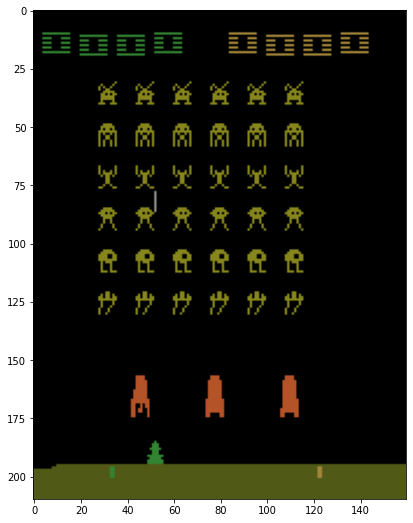

In [23]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

#### In this lab, I recommend you to use the way2 for smoother working ;-)

Take a look at the action space available, and try to get a sample from the action space:

In [24]:
print(env.action_space)
action = env.action_space.sample()
print(action)

Discrete(6)
5


Execute an action using `step()`.
The `step` method returns the next state after the action is taken.
 - **new_state**: The new observation
 - **reward**: The reward associated with that action in that state.
 - **is_done**: A flag to tell the game end (True).
 - **info**: extra information

In [25]:
new_state, reward, is_done, info = env.step(action)
print(is_done)
print(reward)
print(info)

False
0.0
{'lives': 3}


Let's make a *while* loop with a random agent:

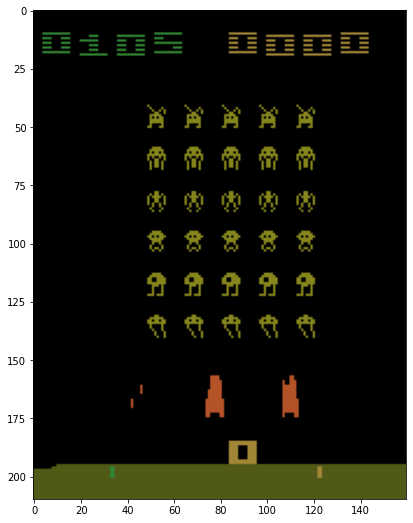

In [26]:
import time

is_done = False
env = gym.make('SpaceInvaders-v0')
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
while not is_done:
    action = env.action_space.sample()
    new_state, reward, is_done, info = env.step(action)
    print(info)
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.03)
env.close()

## Using the environments to do reinforcement learning

## Monte Carlo (MC) Method

Monte Carlo method is a model-free which have no require any prior knowledge of the environment. MC method is more scalable than MDP. MC control is used for finding the optimal policy when a policy is not given. There are basically two types of MC control: on-policy and off-policy. On-policy method learns about the optimal policy by executing the policy and evaluating and improving it, while off-policy methods learn about the optimal policy using information gathered using another policy (usually $\epsilon$-greedy).

## On-policy Monte Carlo control

On-policy Monte Carlo works look-a-like to policy iteration which has 2 phases: evaluation and improvement.
 - Evaluation phase: it evaluates the **action-values** (called **Q-function** $Q(s,a)$) instead of evaluates the value function.
 - Improvement phase: the policy is updated by assigning the optimal action to each stage: $\pi(s)=argmax_a Q(s,a)$

In this code below, we add **epsilon-greedy** policy which it will not exploit the best action all the time. The equations are:
 - Epsilon ($\epsilon$):

      $\pi(s,a)=\frac{\epsilon}{|A|}$  When $|A|$ is the number of all possible actions.
 - Greedy:
 
      $\pi(s,a)=1-\epsilon + \frac{\epsilon}{|A|}$

In [1]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v1')

def run_episode(env, Q, epsilon, n_action):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    # without epsilon-greedy
    # action = torch.randint(0, n_action, [1]).item()
    ##################################################
    while not is_done:
        # with epsilon-greedy
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        #######################################################
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def mc_control_on_policy(env, gamma, n_episode, epsilon):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(env.action_space.n))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            for state_action, return_t in G.items():
                state, action = state_action
                if state[0] <= 21:
                    G_sum[state_action] += return_t
                    N[state_action] += 1
                    Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
epsilon = 0.1
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode, epsilon)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

after episode 100, win  43  lose  45


## Off-policy Monte Carlo control

The Off-policy method optimizes the **target policy** ($\pi$) using data generated by another policy (**behavior policy** ($b$)).
 - Target policy: exploitation purposes, greedy with respect to its current Q-function.
 - Behavior policy: exploration purposes, generate behavior which the target policy used for learning. The behavior policy can be anything to confirm that it can explore all possibilities, then all actions and all states can be chosen with non-zero probabilities.

The weight importand for state-action pair is calculated as:

$w_t=\sum_{k=t}[\pi(a_k|s_k)/b(a_k|s_k)]$
 - $\pi(a_k|s_k)$: probabilities of taking action $a_k$ in state $s_k$
 - $b(a_k|s_k)$: probabilities under the behavior policy.

In [ ]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v0')

def gen_random_policy(n_action):
    probs = torch.ones(n_action) / n_action
    def policy_function(state):
        return probs
    return policy_function

random_policy = gen_random_policy(env.action_space.n)

def run_episode(env, behavior_policy):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = behavior_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

def mc_control_off_policy(env, gamma, n_episode, behavior_policy):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = {}
        w = 1
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            w *= 1./ behavior_policy(state_t)[action_t]
            W[(state_t, action_t)] = w
            if action_t != torch.argmax(Q[state_t]).item():
                break
            
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t * W[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
optimal_Q, optimal_policy = mc_control_off_policy(env, gamma, n_episode, random_policy)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

## Temporal Difference (TD)

Temporal Difference (TD) learning is a model-free learning algorithm like MC learning. In MC learning, Q-function is called and updated at the end of the entire episode, but TD learning update Q-function every step of an episode. One of the TD learning algorithm is Q-learning

## Q-Learning

Q-leaning is an off-policy learning algorithm. The Q-function is based on the equation:

$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a))$

Where
 - $\alpha$: learning rate
 - $\gamma$: discount factor
 - $\max_{a'}Q(s',a')$: greedy behavior policy, the highest Q-value among those in state $s'$ is selected to generate learning data.

We know from class that Q-learning finds the optimal greedy policy while running an epsilon-greedy policy. 

In [ ]:
import importlib
from collections import defaultdict
import torch
import numpy

env_id = "SpaceInvaders-v0"
env = gym.make(env_id)

env.reset()

# defining epsilon-greedy policy
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q, available_actions):
        probs = torch.ones(n_action) * epsilon / n_action
        # print(probs)
        # print(state)
        # print(Q[state])
        best_action = torch.argmax(Q[state]).item()
        if not(best_action in available_actions):
            best_action = -1
            Q_max = -800000000
            for i in range(n_action):
                if i in available_actions and Q_max < Q[state][i]:
                    Q_max = Q[state][i]
                    best_action = i
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

def q_learning(env, gamma, n_episode, alpha, player):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = 9
    Q = defaultdict(lambda: torch.zeros(n_action))
    print('start learning')
    for episode in range(n_episode):
        print("episode: ", episode + 1)
        state = env.reset()
        state = hash(tuple(state.reshape(-1)))

        is_done = False
        while not is_done:
            action = epsilon_greedy_policy(state, Q, available_actions)
            next_state, reward, is_done, info = env.step(action)
            next_state = hash(tuple(next_state.reshape(-1)))
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

### Train it!

In [ ]:
gamma = 1

# the more episodes have been learned, the cleverer will be get.
n_episode = 10

alpha = 0.4

epsilon = 0.1

available_actions = numpy.arange(env.action_space.n)
available_actions = torch.from_numpy(available_actions)
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

# agent play first
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha, 1)


print('The optimal policy:\n', optimal_policy)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
print(total_reward_episode[-100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [ ]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(Q, available_actions):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    state = hash(tuple(state.reshape(-1)))
    while(not done):
        action = epsilon_greedy_policy(state, Q, available_actions)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state
        state = hash(tuple(state.reshape(-1)))

play_game(optimal_Q, available_actions)
env.close()

## Deep Q-Learning

A deep Q-Network (DQN) is similar to a supervised regression model $F_{\theta}$, but it more specifically maps states to action values directly instead of using a set of features.

A DQN is trained to output $Q(s,a)$ values for each action given the input state $s$. In operation, in state $s$, the action $a$ is chosen greedily based on $Q(s,a)$ or stochastically
following an epsilon-greedy policy.

<img src="img/RL2_DQN.png" title="DQN" style="width: 800px;" />

In tabular Q learning, the update rule is an off-policy TD learning rule. When we take
action $a$ in state $s$ receiving reward $r$, we update $Q(s,a)$ as

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a)),$$

where
 - $s'$ is the resulting state after taking action $a$ in state $s$
 - $\max_{a'}Q(s',a')$ is value of the action $a'$ we would take in state $s'$ according to a greedy behavior policy.

A DQN does the same thing using backpropagation, minimizing inconsistencies in its $Q$ estimates. At each step, the difference
between the estimated value and the observed data from the subsequent step should be minimized, giving us a kind of regression
problem, for which a squared error loss function is appopriate, giving us a delta for the $a$th output of

$$\delta_a=r+\gamma\max_{a'}Q(s')_{a'}-Q(s)_{a}.$$

With an appropriate exploration strategy and learning rate, DQN should find the optimal network model best approximating
the state-value function $Q(s,a)$ for each possible state and action.

## DQN Example: Cartpole

Let's develop a sample DQN application step by step. First, some imports we'll need.
We'll use the `gym` package like last week.

In [28]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### $\epsilon$ decay schedule

Recall that some of the theoretical results on TD learning assume $\epsilon$-greedy exploration with $\epsilon$ decaying slowly to 0
over time. Let's define an exponential decay schedule for $\epsilon$. First, an example:


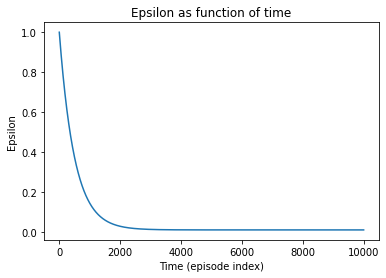

In [29]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Define epsilon as a function of time (episode index)

eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

# Note that the above lambda expression is equivalent to explicitly defining a function:
# def epsilon_episode(episode):
#     return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.title('Epsilon as function of time')
plt.xlabel('Time (episode index)')
plt.ylabel('Epsilon')
plt.show()


Here's a reusable function to generate an annealing schedule function according to given parameters:

In [30]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

### Replay buffer

We know that deep learning methods learn faster when training samples are combined into batches. This speeds up learning and also makes it more stable by averaging
updates over multiple samaples.

RL algorithms also benefit from batched training. However, we see that the standard Q learning rule always updates $Q$ estimates using the most recent experience.
If we always trained on batches consisting of samples of the most recent behavior, correlations between successive state action pairs will make learning less effective.
So we would also like to select random training samples to make them look more like the i.i.d. sampling that supervised learning performs well under.

In RL, the standard way of doing this is to create a large buffer of past state action pairs then form training batches by sampling from that replay buffer.
Our replay buffer will store tuples consisting of an observed state, an action, the next_state, the reward, and the termination signal obtained by the agent at that point in time:

In [31]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### Basic DQN

Next, a basic DQN class. We just create a neural network that takes as input a state
and returns an output vector indiciating the value of each possible action $Q(s,a)$.

The steps we take during learning will be as follows:

<img src="img/RL2_DQNstep.jpeg" title="" style="width: 600px;" />

To implement the policy, besides the usual `forward()` method, we add one additional method `act()`,
which samples an $\epsilon$-greedy action for state $s$ using the current estimate $Q(s,a)$.
`act()` will be used to implement step 1 in the pseudocode above.


In [32]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

### Create gym environment, prepare DQN for training

Next we set up a gym environment for the cartpole simulation, create a DQN model with Adam optimization, and create a replay buffer of length 1000.

In [33]:
env_id = "CartPole-v0"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

### Training step

In the training step, we sample a batch from the replay buffer, calculate $Q(s,a)$ and $\max_{a'} Q(s',a')$, calculate
the target $Q$ value $r + \gamma\max_{a'}Q(s',a')$, the mean squared loss between the predicted and target $Q$ values,
and then backpropagate.


In [34]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    print(action.shape)
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    print(q_value.shape)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Plot rewards and losses

Here's a little function to plot relevant details for us:

In [35]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

### Training loop

The training loop lets the agent play the game until the end of the episode.
Each step is appended to the replay buffer. We don't do any learning until the buffer's length reaches the batch_size.


In [36]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done, _ = env.step(action)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

### Train!

Let's train our DQN model for 10,000 steps in the cartpole simulation:

Agent training (episode33) Avg Reward 0.9696969696969697:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_29016/667146523.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode43) Avg Reward 0.9767441860465116:   0%|          | 42/10001 [00:00<00:24, 403.86it/s]C:\Users\THETANG\AppData\Local\Temp/ipykernel_29016/2776276185.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode71) Avg Reward 0.9859154929577465:   0%|          | 42/10001 [00:00<00:24, 403.86it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode109) Avg Reward 0.9908256880733946:   1%|          | 83/10001 [00:00<00:38, 256.19it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode149) Avg Reward 0.9932885906040269:   1%|▏         | 137/10001 [00:00<00:42, 230.12it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode187) Avg Reward 0.9946524064171123:   2%|▏         | 184/10001 [00:00<00:45, 213.81it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode226) Avg Reward 0.995575221238938:   2%|▏         | 206/10001 [00:00<00:45, 213.75it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode265) Avg Reward 0.9962264150943396:   2%|▏         | 250/10001 [00:01<00:46, 210.39it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode306) Avg Reward 0.9967320261437909:   3%|▎         | 294/10001 [00:01<00:45, 211.39it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode345) Avg Reward 0.9971014492753624:   3%|▎         | 339/10001 [00:01<00:45, 213.47it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode382) Avg Reward 0.9973821989528796:   4%|▎         | 361/10001 [00:01<00:45, 211.08it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode422) Avg Reward 0.9976303317535545:   4%|▍         | 406/10001 [00:01<00:46, 207.34it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode462) Avg Reward 0.9978354978354979:   4%|▍         | 450/10001 [00:02<00:45, 210.21it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode502) Avg Reward 0.99800796812749:   5%|▍         | 495/10001 [00:02<00:45, 209.24it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode541) Avg Reward 0.9981515711645101:   5%|▌         | 539/10001 [00:02<00:45, 208.08it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode581) Avg Reward 0.9982788296041308:   6%|▌         | 561/10001 [00:02<00:44, 211.50it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode619) Avg Reward 0.9983844911147012:   6%|▌         | 605/10001 [00:02<00:45, 207.93it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode658) Avg Reward 0.9984802431610942:   6%|▋         | 649/10001 [00:03<00:44, 208.80it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode699) Avg Reward 0.9985693848354793:   7%|▋         | 693/10001 [00:03<00:44, 210.25it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode737) Avg Reward 0.9986431478968792:   7%|▋         | 737/10001 [00:03<00:44, 208.74it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode777) Avg Reward 0.9987129987129987:   8%|▊         | 759/10001 [00:03<00:43, 210.17it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode814) Avg Reward 0.9987714987714987:   8%|▊         | 802/10001 [00:03<00:44, 205.98it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode850) Avg Reward 0.9988235294117647:   8%|▊         | 844/10001 [00:03<00:46, 196.33it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode883) Avg Reward 0.9988674971687429:   9%|▊         | 864/10001 [00:04<00:48, 186.80it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode921) Avg Reward 0.998914223669924:   9%|▉         | 906/10001 [00:04<00:46, 195.44it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode959) Avg Reward 0.9989572471324296:   9%|▉         | 948/10001 [00:04<00:45, 197.74it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode995) Avg Reward 0.9989949748743718:  10%|▉         | 989/10001 [00:04<00:45, 198.70it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1030) Avg Reward 0.9990291262135922:  10%|█         | 1029/10001 [00:04<00:47, 190.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1065) Avg Reward 0.9990610328638497:  10%|█         | 1049/10001 [00:05<00:48, 185.43it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1104) Avg Reward 0.9990942028985508:  11%|█         | 1091/10001 [00:05<00:45, 193.87it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1144) Avg Reward 0.9991258741258742:  11%|█▏        | 1135/10001 [00:05<00:43, 202.10it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1186) Avg Reward 0.9991568296795953:  12%|█▏        | 1182/10001 [00:05<00:41, 212.12it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1223) Avg Reward 0.9991823385118561:  12%|█▏        | 1205/10001 [00:05<00:40, 214.81it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1260) Avg Reward 0.9992063492063492:  12%|█▏        | 1248/10001 [00:06<00:43, 202.36it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1300) Avg Reward 0.9992307692307693:  13%|█▎        | 1291/10001 [00:06<00:42, 203.19it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1340) Avg Reward 0.9992537313432835:  13%|█▎        | 1336/10001 [00:06<00:41, 208.27it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1381) Avg Reward 0.999275887038378:  14%|█▎        | 1359/10001 [00:06<00:40, 214.53it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1420) Avg Reward 0.9992957746478873:  14%|█▍        | 1403/10001 [00:06<00:40, 213.38it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1456) Avg Reward 0.9993131868131868:  14%|█▍        | 1447/10001 [00:06<00:43, 197.56it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1495) Avg Reward 0.9993311036789297:  15%|█▍        | 1494/10001 [00:07<00:41, 204.59it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1534) Avg Reward 0.999348109517601:  15%|█▌        | 1516/10001 [00:07<00:40, 207.15it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1575) Avg Reward 0.9993650793650793:  16%|█▌        | 1559/10001 [00:07<00:40, 208.19it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1614) Avg Reward 0.9993804213135068:  16%|█▌        | 1604/10001 [00:07<00:40, 207.38it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1653) Avg Reward 0.999395039322444:  16%|█▋        | 1648/10001 [00:07<00:40, 207.58it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1693) Avg Reward 0.9994093325457767:  17%|█▋        | 1693/10001 [00:08<00:39, 211.99it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1733) Avg Reward 0.9994229659549914:  17%|█▋        | 1715/10001 [00:08<00:38, 213.08it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1770) Avg Reward 0.9994350282485875:  18%|█▊        | 1759/10001 [00:08<00:40, 205.71it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1806) Avg Reward 0.9994462901439646:  18%|█▊        | 1801/10001 [00:08<00:41, 198.68it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1841) Avg Reward 0.9994568169473113:  18%|█▊        | 1821/10001 [00:08<00:42, 193.03it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1880) Avg Reward 0.999468085106383:  19%|█▊        | 1863/10001 [00:09<00:40, 198.70it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1917) Avg Reward 0.9994783515910276:  19%|█▉        | 1906/10001 [00:09<00:40, 201.33it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1949) Avg Reward 0.9994869163673679:  19%|█▉        | 1947/10001 [00:09<00:43, 183.44it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode1983) Avg Reward 0.9994957135653051:  20%|█▉        | 1966/10001 [00:09<00:43, 183.73it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2022) Avg Reward 0.9995054401582592:  20%|██        | 2008/10001 [00:09<00:41, 194.09it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2054) Avg Reward 0.9995131450827653:  20%|██        | 2048/10001 [00:09<00:42, 186.67it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2093) Avg Reward 0.9995222169135213:  21%|██        | 2089/10001 [00:10<00:40, 193.14it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2128) Avg Reward 0.9995300751879699:  21%|██        | 2109/10001 [00:10<00:41, 190.73it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2168) Avg Reward 0.9995387453874539:  21%|██▏       | 2150/10001 [00:10<00:40, 195.70it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2207) Avg Reward 0.9995468962392388:  22%|██▏       | 2194/10001 [00:10<00:38, 204.30it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2245) Avg Reward 0.999554565701559:  22%|██▏       | 2236/10001 [00:10<00:39, 198.67it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2283) Avg Reward 0.9995619798510732:  23%|██▎       | 2280/10001 [00:11<00:37, 203.38it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2323) Avg Reward 0.9995695221696083:  23%|██▎       | 2301/10001 [00:11<00:37, 204.70it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2357) Avg Reward 0.9995757318625371:  23%|██▎       | 2345/10001 [00:11<00:37, 202.65it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2395) Avg Reward 0.9995824634655532:  24%|██▍       | 2388/10001 [00:11<00:38, 198.18it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2434) Avg Reward 0.9995891536565324:  24%|██▍       | 2432/10001 [00:11<00:37, 202.06it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2470) Avg Reward 0.9995951417004049:  25%|██▍       | 2453/10001 [00:12<00:37, 199.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2504) Avg Reward 0.9996006389776357:  25%|██▍       | 2494/10001 [00:12<00:39, 189.67it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2544) Avg Reward 0.9996069182389937:  25%|██▌       | 2536/10001 [00:12<00:37, 196.94it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2580) Avg Reward 0.9996124031007751:  26%|██▌       | 2580/10001 [00:12<00:37, 196.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2619) Avg Reward 0.9996181748759069:  26%|██▌       | 2602/10001 [00:12<00:36, 202.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2656) Avg Reward 0.9996234939759037:  26%|██▋       | 2644/10001 [00:12<00:36, 201.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2692) Avg Reward 0.99962852897474:  27%|██▋       | 2685/10001 [00:13<00:38, 192.21it/s]  

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2731) Avg Reward 0.9996338337605273:  27%|██▋       | 2729/10001 [00:13<00:36, 199.94it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2770) Avg Reward 0.9996389891696751:  27%|██▋       | 2750/10001 [00:13<00:36, 197.73it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2806) Avg Reward 0.9996436208125445:  28%|██▊       | 2793/10001 [00:13<00:35, 200.91it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2844) Avg Reward 0.999648382559775:  28%|██▊       | 2836/10001 [00:13<00:35, 200.95it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2885) Avg Reward 0.9996533795493934:  29%|██▉       | 2881/10001 [00:14<00:34, 208.28it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2924) Avg Reward 0.9996580027359782:  29%|██▉       | 2904/10001 [00:14<00:33, 210.89it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode2964) Avg Reward 0.9996626180836707:  29%|██▉       | 2948/10001 [00:14<00:33, 209.65it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3001) Avg Reward 0.9996667777407531:  30%|██▉       | 2993/10001 [00:14<00:33, 207.11it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3042) Avg Reward 0.9996712689020382:  30%|███       | 3037/10001 [00:14<00:33, 208.87it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3081) Avg Reward 0.9996754300551769:  31%|███       | 3060/10001 [00:15<00:32, 212.50it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3121) Avg Reward 0.99967958987504:  31%|███       | 3104/10001 [00:15<00:32, 211.52it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3162) Avg Reward 0.9996837444655281:  31%|███▏      | 3148/10001 [00:15<00:32, 213.00it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3203) Avg Reward 0.999687792694349:  32%|███▏      | 3193/10001 [00:15<00:31, 213.72it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3242) Avg Reward 0.999691548426897:  32%|███▏      | 3238/10001 [00:15<00:31, 214.07it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3281) Avg Reward 0.9996952148735142:  33%|███▎      | 3260/10001 [00:15<00:31, 211.48it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3321) Avg Reward 0.9996988858777477:  33%|███▎      | 3304/10001 [00:16<00:31, 212.06it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3363) Avg Reward 0.999702646446625:  33%|███▎      | 3348/10001 [00:16<00:31, 213.27it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3403) Avg Reward 0.9997061416397296:  34%|███▍      | 3394/10001 [00:16<00:30, 214.20it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3444) Avg Reward 0.9997096399535423:  34%|███▍      | 3440/10001 [00:16<00:30, 215.02it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3484) Avg Reward 0.9997129735935706:  35%|███▍      | 3463/10001 [00:16<00:29, 218.72it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3523) Avg Reward 0.999716151007664:  35%|███▌      | 3507/10001 [00:17<00:30, 210.09it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3559) Avg Reward 0.9997190221972464:  36%|███▌      | 3552/10001 [00:17<00:30, 210.24it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3595) Avg Reward 0.9997218358831711:  36%|███▌      | 3574/10001 [00:17<00:31, 201.48it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3636) Avg Reward 0.9997249724972497:  36%|███▌      | 3618/10001 [00:17<00:31, 202.31it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3676) Avg Reward 0.999727965179543:  37%|███▋      | 3661/10001 [00:17<00:30, 207.05it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3714) Avg Reward 0.9997307485191168:  37%|███▋      | 3706/10001 [00:18<00:31, 202.62it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3756) Avg Reward 0.9997337593184239:  38%|███▊      | 3752/10001 [00:18<00:29, 212.02it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3796) Avg Reward 0.9997365648050579:  38%|███▊      | 3775/10001 [00:18<00:28, 215.95it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3837) Avg Reward 0.9997393797237425:  38%|███▊      | 3819/10001 [00:18<00:28, 216.19it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3877) Avg Reward 0.9997420686097498:  39%|███▊      | 3864/10001 [00:18<00:28, 213.98it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3917) Avg Reward 0.999744702578504:  39%|███▉      | 3909/10001 [00:18<00:28, 212.37it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3955) Avg Reward 0.9997471554993679:  40%|███▉      | 3953/10001 [00:19<00:28, 209.61it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode3996) Avg Reward 0.9997497497497497:  40%|███▉      | 3975/10001 [00:19<00:28, 210.18it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4036) Avg Reward 0.9997522299306244:  40%|████      | 4020/10001 [00:19<00:28, 213.19it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4073) Avg Reward 0.999754480726737:  41%|████      | 4063/10001 [00:19<00:28, 206.22it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4113) Avg Reward 0.99975686846584:  41%|████      | 4106/10001 [00:19<00:28, 206.70it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4150) Avg Reward 0.9997590361445783:  41%|████▏     | 4148/10001 [00:20<00:28, 204.10it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4186) Avg Reward 0.9997611084567606:  42%|████▏     | 4169/10001 [00:20<00:29, 197.76it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4228) Avg Reward 0.999763481551561:  42%|████▏     | 4213/10001 [00:20<00:28, 206.26it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4269) Avg Reward 0.9997657531037714:  43%|████▎     | 4259/10001 [00:20<00:26, 212.96it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4310) Avg Reward 0.9997679814385151:  43%|████▎     | 4305/10001 [00:20<00:26, 217.06it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4349) Avg Reward 0.9997700620832375:  43%|████▎     | 4349/10001 [00:21<00:26, 214.75it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4387) Avg Reward 0.9997720537953043:  44%|████▎     | 4371/10001 [00:21<00:26, 212.56it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4426) Avg Reward 0.999774062358789:  44%|████▍     | 4414/10001 [00:21<00:26, 209.04it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4462) Avg Reward 0.9997758852532497:  45%|████▍     | 4456/10001 [00:21<00:28, 195.94it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4502) Avg Reward 0.9997778764993336:  45%|████▍     | 4500/10001 [00:21<00:26, 205.99it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4541) Avg Reward 0.9997797841885048:  45%|████▌     | 4521/10001 [00:21<00:26, 206.56it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4580) Avg Reward 0.9997816593886463:  46%|████▌     | 4563/10001 [00:22<00:26, 202.26it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4620) Avg Reward 0.9997835497835498:  46%|████▌     | 4610/10001 [00:22<00:25, 209.99it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4658) Avg Reward 0.9997853155860884:  47%|████▋     | 4653/10001 [00:22<00:25, 207.26it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4698) Avg Reward 0.9997871434653044:  47%|████▋     | 4697/10001 [00:22<00:25, 210.71it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4739) Avg Reward 0.9997889850179362:  47%|████▋     | 4720/10001 [00:22<00:24, 215.07it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4780) Avg Reward 0.9997907949790795:  48%|████▊     | 4764/10001 [00:23<00:24, 212.47it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4820) Avg Reward 0.999792531120332:  48%|████▊     | 4809/10001 [00:23<00:24, 214.69it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4860) Avg Reward 0.9997942386831276:  49%|████▊     | 4856/10001 [00:23<00:24, 212.28it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4902) Avg Reward 0.9997960016319869:  49%|████▉     | 4880/10001 [00:23<00:23, 216.48it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4941) Avg Reward 0.9997976118194697:  49%|████▉     | 4925/10001 [00:23<00:23, 216.22it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode4981) Avg Reward 0.9997992371009837:  50%|████▉     | 4969/10001 [00:24<00:24, 209.65it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5020) Avg Reward 0.999800796812749:  50%|█████     | 5013/10001 [00:24<00:23, 207.88it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5057) Avg Reward 0.9998022543009689:  51%|█████     | 5056/10001 [00:24<00:23, 207.05it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5095) Avg Reward 0.9998037291462217:  51%|█████     | 5077/10001 [00:24<00:24, 202.06it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5135) Avg Reward 0.9998052580331062:  51%|█████     | 5121/10001 [00:24<00:23, 208.50it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5174) Avg Reward 0.9998067259373792:  52%|█████▏    | 5163/10001 [00:24<00:23, 205.33it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5211) Avg Reward 0.9998080982536941:  52%|█████▏    | 5206/10001 [00:25<00:23, 205.08it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5251) Avg Reward 0.9998095600837935:  52%|█████▏    | 5249/10001 [00:25<00:22, 208.12it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5292) Avg Reward 0.9998110355253212:  53%|█████▎    | 5271/10001 [00:25<00:22, 211.00it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5331) Avg Reward 0.9998124179328456:  53%|█████▎    | 5315/10001 [00:25<00:22, 211.26it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5367) Avg Reward 0.999813676169182:  54%|█████▎    | 5358/10001 [00:25<00:22, 205.01it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5402) Avg Reward 0.9998148833765272:  54%|█████▍    | 5400/10001 [00:26<00:23, 193.57it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5441) Avg Reward 0.9998162102554677:  54%|█████▍    | 5422/10001 [00:26<00:22, 199.86it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5481) Avg Reward 0.9998175515416895:  55%|█████▍    | 5465/10001 [00:26<00:22, 205.30it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5516) Avg Reward 0.9998187092095722:  55%|█████▌    | 5507/10001 [00:26<00:22, 199.91it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5555) Avg Reward 0.9998199819981998:  55%|█████▌    | 5549/10001 [00:26<00:22, 201.50it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5591) Avg Reward 0.9998211411196566:  56%|█████▌    | 5590/10001 [00:27<00:22, 197.37it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5628) Avg Reward 0.999822316986496:  56%|█████▌    | 5610/10001 [00:27<00:22, 195.87it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5666) Avg Reward 0.9998235086480762:  57%|█████▋    | 5652/10001 [00:27<00:21, 200.32it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5703) Avg Reward 0.9998246536910398:  57%|█████▋    | 5694/10001 [00:27<00:21, 198.45it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5740) Avg Reward 0.9998257839721254:  57%|█████▋    | 5736/10001 [00:27<00:21, 196.16it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5779) Avg Reward 0.9998269596816058:  58%|█████▊    | 5759/10001 [00:27<00:20, 202.95it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5819) Avg Reward 0.9998281491665234:  58%|█████▊    | 5801/10001 [00:28<00:20, 203.18it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5858) Avg Reward 0.999829293274155:  58%|█████▊    | 5844/10001 [00:28<00:19, 208.21it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5897) Avg Reward 0.999830422248601:  59%|█████▉    | 5887/10001 [00:28<00:19, 206.23it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5936) Avg Reward 0.9998315363881402:  59%|█████▉    | 5930/10001 [00:28<00:19, 206.12it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode5972) Avg Reward 0.9998325519089082:  60%|█████▉    | 5972/10001 [00:28<00:19, 201.47it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6010) Avg Reward 0.9998336106489185:  60%|█████▉    | 5994/10001 [00:29<00:19, 205.65it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6047) Avg Reward 0.9998346287415247:  60%|██████    | 6036/10001 [00:29<00:19, 199.33it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6085) Avg Reward 0.9998356614626129:  61%|██████    | 6078/10001 [00:29<00:19, 200.07it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6122) Avg Reward 0.9998366546880104:  61%|██████    | 6120/10001 [00:29<00:19, 197.22it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6158) Avg Reward 0.9998376096135109:  61%|██████▏   | 6140/10001 [00:29<00:19, 196.89it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6195) Avg Reward 0.9998385794995964:  62%|██████▏   | 6180/10001 [00:30<00:19, 194.40it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6231) Avg Reward 0.9998395121168352:  62%|██████▏   | 6220/10001 [00:30<00:19, 193.94it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6267) Avg Reward 0.9998404340194671:  63%|██████▎   | 6260/10001 [00:30<00:19, 193.12it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6304) Avg Reward 0.9998413705583756:  63%|██████▎   | 6300/10001 [00:30<00:18, 195.01it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6341) Avg Reward 0.9998422961677969:  63%|██████▎   | 6341/10001 [00:30<00:18, 198.01it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6378) Avg Reward 0.9998432110379429:  64%|██████▎   | 6362/10001 [00:30<00:18, 199.78it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6413) Avg Reward 0.9998440667394355:  64%|██████▍   | 6402/10001 [00:31<00:18, 192.75it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6451) Avg Reward 0.999844985273601:  64%|██████▍   | 6443/10001 [00:31<00:18, 195.72it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6487) Avg Reward 0.9998458455372283:  65%|██████▍   | 6483/10001 [00:31<00:18, 194.64it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6524) Avg Reward 0.9998467198038014:  65%|██████▌   | 6504/10001 [00:31<00:17, 197.98it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6562) Avg Reward 0.999847607436757:  65%|██████▌   | 6546/10001 [00:31<00:17, 200.24it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6598) Avg Reward 0.9998484389208852:  66%|██████▌   | 6587/10001 [00:32<00:17, 196.39it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6634) Avg Reward 0.9998492613807658:  66%|██████▋   | 6627/10001 [00:32<00:17, 191.19it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6670) Avg Reward 0.9998500749625188:  67%|██████▋   | 6668/10001 [00:32<00:17, 193.59it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6707) Avg Reward 0.999850902042642:  67%|██████▋   | 6688/10001 [00:32<00:17, 193.76it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6746) Avg Reward 0.9998517640083012:  67%|██████▋   | 6729/10001 [00:32<00:16, 198.82it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6779) Avg Reward 0.9998524856173477:  68%|██████▊   | 6771/10001 [00:33<00:17, 188.80it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6815) Avg Reward 0.9998532648569333:  68%|██████▊   | 6811/10001 [00:33<00:16, 187.96it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6853) Avg Reward 0.9998540785057639:  68%|██████▊   | 6832/10001 [00:33<00:16, 193.11it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6890) Avg Reward 0.9998548621190131:  69%|██████▊   | 6874/10001 [00:33<00:15, 197.16it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode6928) Avg Reward 0.9998556581986143:  69%|██████▉   | 6914/10001 [00:33<00:15, 196.84it/s]


torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([3

Agent training (episode6966) Avg Reward 0.9998564455928797:  70%|██████▉   | 6957/10001 [00:33<00:15, 199.79it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7002) Avg Reward 0.9998571836618109:  70%|██████▉   | 6999/10001 [00:34<00:15, 196.58it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7039) Avg Reward 0.9998579343656769:  70%|███████   | 7019/10001 [00:34<00:15, 194.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7076) Avg Reward 0.9998586772187676:  71%|███████   | 7061/10001 [00:34<00:14, 198.78it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7115) Avg Reward 0.9998594518622628:  71%|███████   | 7103/10001 [00:34<00:14, 200.61it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7153) Avg Reward 0.9998601985181043:  71%|███████▏  | 7145/10001 [00:34<00:14, 201.33it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7191) Avg Reward 0.9998609372827145:  72%|███████▏  | 7187/10001 [00:35<00:14, 200.37it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7226) Avg Reward 0.9998616108497094:  72%|███████▏  | 7208/10001 [00:35<00:13, 199.69it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7262) Avg Reward 0.9998622968879096:  72%|███████▏  | 7248/10001 [00:35<00:14, 190.74it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7300) Avg Reward 0.9998630136986302:  73%|███████▎  | 7290/10001 [00:35<00:13, 196.62it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7340) Avg Reward 0.9998637602179836:  73%|███████▎  | 7334/10001 [00:35<00:12, 208.28it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7378) Avg Reward 0.9998644619137977:  74%|███████▍  | 7376/10001 [00:36<00:12, 203.60it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7417) Avg Reward 0.9998651745988945:  74%|███████▍  | 7397/10001 [00:36<00:12, 204.27it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7455) Avg Reward 0.9998658618376928:  74%|███████▍  | 7440/10001 [00:36<00:12, 205.87it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7493) Avg Reward 0.9998665421059656:  75%|███████▍  | 7482/10001 [00:36<00:12, 199.86it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7532) Avg Reward 0.9998672331386086:  75%|███████▌  | 7526/10001 [00:36<00:11, 208.03it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7569) Avg Reward 0.9998678821508786:  76%|███████▌  | 7568/10001 [00:36<00:12, 201.30it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7606) Avg Reward 0.9998685248488036:  76%|███████▌  | 7589/10001 [00:37<00:11, 203.23it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7644) Avg Reward 0.999869178440607:  76%|███████▋  | 7630/10001 [00:37<00:11, 198.36it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7678) Avg Reward 0.9998697577494139:  77%|███████▋  | 7671/10001 [00:37<00:11, 194.45it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7716) Avg Reward 0.9998703991705546:  77%|███████▋  | 7713/10001 [00:37<00:11, 197.90it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7755) Avg Reward 0.9998710509348807:  77%|███████▋  | 7733/10001 [00:37<00:11, 194.57it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7792) Avg Reward 0.9998716632443532:  78%|███████▊  | 7778/10001 [00:38<00:10, 202.42it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7831) Avg Reward 0.9998723023879453:  78%|███████▊  | 7820/10001 [00:38<00:10, 200.97it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7868) Avg Reward 0.9998729028978139:  79%|███████▊  | 7863/10001 [00:38<00:10, 201.95it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7901) Avg Reward 0.9998734337425642:  79%|███████▉  | 7884/10001 [00:38<00:10, 193.13it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7937) Avg Reward 0.9998740078115157:  79%|███████▉  | 7924/10001 [00:38<00:10, 193.25it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode7972) Avg Reward 0.9998745609633718:  80%|███████▉  | 7964/10001 [00:39<00:10, 186.86it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8008) Avg Reward 0.9998751248751249:  80%|████████  | 8004/10001 [00:39<00:10, 190.71it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8045) Avg Reward 0.9998756991920448:  80%|████████  | 8045/10001 [00:39<00:10, 193.52it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8083) Avg Reward 0.9998762835580849:  81%|████████  | 8065/10001 [00:39<00:10, 192.60it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8116) Avg Reward 0.9998767865943815:  81%|████████  | 8106/10001 [00:39<00:10, 187.99it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8147) Avg Reward 0.9998772554314471:  81%|████████▏ | 8144/10001 [00:39<00:10, 176.40it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8180) Avg Reward 0.999877750611247:  82%|████████▏ | 8162/10001 [00:40<00:10, 175.45it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8215) Avg Reward 0.9998782714546561:  82%|████████▏ | 8199/10001 [00:40<00:10, 177.24it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8243) Avg Reward 0.9998786849448017:  82%|████████▏ | 8237/10001 [00:40<00:09, 178.67it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])


Agent training (episode8279) Avg Reward 0.9998792124652736:  83%|████████▎ | 8275/10001 [00:40<00:09, 175.20it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8314) Avg Reward 0.99987972095261:  83%|████████▎ | 8313/10001 [00:40<00:09, 181.70it/s]  

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8349) Avg Reward 0.9998802251766679:  83%|████████▎ | 8333/10001 [00:41<00:08, 185.94it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8389) Avg Reward 0.9998807962808439:  84%|████████▎ | 8374/10001 [00:41<00:08, 194.06it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8432) Avg Reward 0.999881404174573:  84%|████████▍ | 8420/10001 [00:41<00:07, 210.07it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8470) Avg Reward 0.9998819362455726:  85%|████████▍ | 8465/10001 [00:41<00:07, 207.84it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8507) Avg Reward 0.9998824497472669:  85%|████████▍ | 8487/10001 [00:41<00:07, 208.35it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8546) Avg Reward 0.9998829861923707:  85%|████████▌ | 8529/10001 [00:42<00:07, 202.61it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8588) Avg Reward 0.9998835584536563:  86%|████████▌ | 8574/10001 [00:42<00:06, 210.21it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8629) Avg Reward 0.9998841117163055:  86%|████████▌ | 8619/10001 [00:42<00:06, 217.38it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8672) Avg Reward 0.9998846863468634:  87%|████████▋ | 8665/10001 [00:42<00:06, 222.15it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8710) Avg Reward 0.9998851894374282:  87%|████████▋ | 8688/10001 [00:42<00:05, 223.81it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8745) Avg Reward 0.9998856489422527:  87%|████████▋ | 8733/10001 [00:42<00:06, 203.12it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8782) Avg Reward 0.9998861307219312:  88%|████████▊ | 8774/10001 [00:43<00:06, 196.29it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8822) Avg Reward 0.9998866470188166:  88%|████████▊ | 8818/10001 [00:43<00:05, 205.40it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8863) Avg Reward 0.9998871713866636:  88%|████████▊ | 8840/10001 [00:43<00:05, 209.62it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8907) Avg Reward 0.9998877287526664:  89%|████████▉ | 8887/10001 [00:43<00:05, 218.77it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8947) Avg Reward 0.9998882306918521:  89%|████████▉ | 8934/10001 [00:43<00:04, 219.04it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode8987) Avg Reward 0.999888728162902:  90%|████████▉ | 8978/10001 [00:44<00:04, 212.08it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9027) Avg Reward 0.9998892212252133:  90%|█████████ | 9024/10001 [00:44<00:04, 216.85it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9065) Avg Reward 0.9998896856039713:  90%|█████████ | 9046/10001 [00:44<00:04, 209.25it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9105) Avg Reward 0.999890170236134:  91%|█████████ | 9088/10001 [00:44<00:04, 208.17it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9146) Avg Reward 0.9998906625847365:  91%|█████████▏| 9133/10001 [00:44<00:04, 214.50it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9187) Avg Reward 0.9998911505388048:  92%|█████████▏| 9179/10001 [00:45<00:03, 219.17it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9224) Avg Reward 0.9998915871639202:  92%|█████████▏| 9223/10001 [00:45<00:03, 208.80it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9266) Avg Reward 0.9998920785668034:  92%|█████████▏| 9246/10001 [00:45<00:03, 211.25it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9308) Avg Reward 0.9998925655350236:  93%|█████████▎| 9293/10001 [00:45<00:03, 219.05it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9349) Avg Reward 0.9998930366884159:  93%|█████████▎| 9338/10001 [00:45<00:03, 219.18it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9384) Avg Reward 0.9998934356351236:  94%|█████████▍| 9381/10001 [00:45<00:03, 206.44it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9425) Avg Reward 0.999893899204244:  94%|█████████▍| 9402/10001 [00:46<00:02, 206.28it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9464) Avg Reward 0.999894336432798:  94%|█████████▍| 9447/10001 [00:46<00:02, 211.19it/s] 

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9504) Avg Reward 0.9998947811447811:  95%|█████████▍| 9491/10001 [00:46<00:02, 209.56it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9546) Avg Reward 0.9998952440812906:  95%|█████████▌| 9538/10001 [00:46<00:02, 218.51it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9587) Avg Reward 0.9998956920830291:  96%|█████████▌| 9583/10001 [00:46<00:01, 218.06it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9630) Avg Reward 0.9998961578400831:  96%|█████████▋| 9630/10001 [00:47<00:01, 224.33it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9673) Avg Reward 0.9998966194562183:  97%|█████████▋| 9653/10001 [00:47<00:01, 225.34it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9712) Avg Reward 0.9998970345963756:  97%|█████████▋| 9699/10001 [00:47<00:01, 223.17it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9744) Avg Reward 0.9998973727422004:  97%|█████████▋| 9722/10001 [00:47<00:01, 214.50it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9782) Avg Reward 0.9998977714168882:  98%|█████████▊| 9764/10001 [00:47<00:01, 195.24it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9821) Avg Reward 0.9998981773750127:  98%|█████████▊| 9807/10001 [00:48<00:00, 201.92it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9854) Avg Reward 0.9998985183681753:  98%|█████████▊| 9849/10001 [00:48<00:00, 193.27it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9889) Avg Reward 0.9998988775407018:  99%|█████████▊| 9869/10001 [00:48<00:00, 189.84it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9926) Avg Reward 0.9998992544831755:  99%|█████████▉| 9910/10001 [00:48<00:00, 192.04it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode9963) Avg Reward 0.9998996286259159:  99%|█████████▉| 9950/10001 [00:48<00:00, 192.88it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode10000) Avg Reward 0.9999: 100%|█████████▉| 9991/10001 [00:48<00:00, 197.37it/s]

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

Agent training (episode10001) Avg Reward 0.9999000099990001: 100%|██████████| 10001/10001 [00:49<00:00, 204.09it/s]


torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])


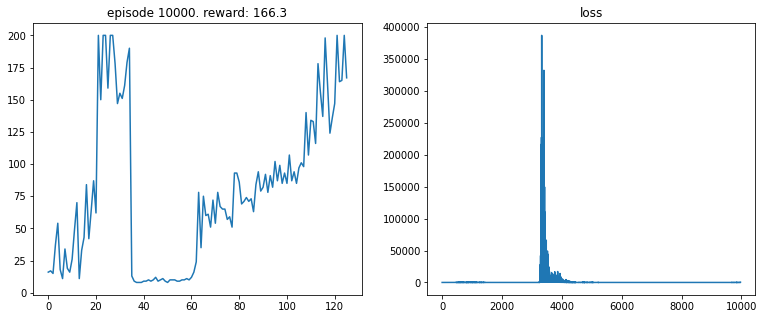

In [37]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

### Play in the simulation

You can run your simulation in Jupyter if you have OpenGL installed, but after the simulation is finished, you must close the
simulator with `env.close()` (this closes the simulator, not the environment).

In [ ]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(model):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state

play_game(model)
env.close()

### In class exercise (50 points)

Apply DQN to the CarRacing-v0 environment.
    

### Take home exercise (50 points)

Apply DQN to Space Invaders. How well can you score?

In [ ]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    print(action.shape)
    print((action.unsqueeze(1)).shape)
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()
        self.n_state = n_state
        self.layers1 = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU()
        )                 
        self.layers2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU()
        )                 
        self.layers3 = nn.Sequential(
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        print("n_state", self.n_state)
        print("1", x.shape)
        x = self.layers1(x)
        print("2", x.shape)
        x = self.layers2(x)
        print("3", x.shape)
        x = self.layers3(x)
        print("4", x.shape)
        return x
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

In [ ]:
env_id = "SpaceInvaders-v0"
env_SpaceInvaders = gym.make(env_id)
env_SpaceInvaders.reset()
n_state = env_SpaceInvaders.observation_space.shape[0]*env_SpaceInvaders.observation_space.shape[1]
n_state = env_SpaceInvaders.observation_space.shape[2]
model = DQN(n_state, env_SpaceInvaders.action_space.n).to(device)
print(n_state, env_SpaceInvaders.action_space.n)

optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [ ]:
model,all_rewards, losses = train(env_SpaceInvaders, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)